In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [ ]:
# export
from FLAI.detect_symbol.exp import databunch
from FLAI.detect_symbol.exp import resnet_ssd as resnet_ssd_detsym
from FLAI.detect_symbol.exp import anchors_loss_metrics as anchors_loss_metrics_detsym
from FLAI.detect_symbol.exp import interpretation as interpretation_detsym

In [ ]:
# export
import sys
if '..' not in sys.path:
    sys.path.append('..')
from exp import anchors_loss_metrics
from exp import resnet_ssd

In [ ]:
# export
import torch

In [ ]:
# export
from torch import tensor

In [ ]:
# export
import torchvision

In [ ]:
# export
from fastai.basic_train import Learner

In [ ]:
# export
from matplotlib import pyplot as plt

In [ ]:
# export
from matplotlib import patches,patheffects

In [ ]:
# export
from IPython.core import debugger as idb

In [ ]:
from fastai.vision.image import Image

In [ ]:
from functools import partial

In [ ]:
# export
from math import ceil

In [ ]:
# export
import pandas as pd

# functions

### show_gt

In [ ]:
def show_gt(x,y):
    img = data.denorm(x)[0].permute(1,2,0)

    _,ax = plt.subplots(1,1,figsize=(15,15))
    ax.imshow(img)
    
    for bb,cat in zip(y[0][0],y[1][0]):
        bb = (bb+1)/2*776
        interpretation_detsym.draw_rect(ax,bb,lw=1)
        
        cat = cat-1
        clas = classes[cat]
        interpretation_detsym.draw_text(ax,bb[[3,0]],clas[:3],sz=10)

### show_gt_anchors

In [ ]:
def show_gt_anchors(x,y,device,n=10):
    '根据ground truch找到负责idxs，绘制这些idxs对应的anchor'
    _,ax = plt.subplots(1,1,figsize=(20,20))
    img = data.denorm(x)[0].permute(1,2,0)
    ax.imshow(img)
    #import pdb; pdb.set_trace()    
    idxs = idx_from_gt(*y,gaf=gaf)
    for idx in idxs:
        gv = gvs[idx]*x.shape[-1]
        interpretation_detsym.draw_rect(ax,gv,lw=1,color='g')
        
        cx = gv[[0,2]].mean()
        cy = gv[[1,3]].mean()
        
        av = avs[idx]*x.shape[-1]
        av = av+tensor([cx,cy,cx,cy]).to(device)
        interpretation_detsym.draw_rect(ax,av,lw=1)
        

        interpretation_detsym.draw_text(ax,av[[3,0]],f'{idx}',sz=10)
    return idxs

###  idx_from_gt

In [ ]:
def idx_from_gt(*gt_batch, gaf):
    loss = 0
    cnt = 0
    for gt_bboxs in gt_batch[0]:
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
          
        gt_bboxs = gt_bboxs[keep]
        
        gt_bboxs = (gt_bboxs + 1) / 2
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        return idx

In [ ]:
def process_netout(txys,cats,confs,gaf):
    ts = torch.cat([txys],dim=-1)
    boxs = gaf.c2b(ts, torch.arange(start = 0, end = ts.shape[-2], device=ts.device))
    
    confs = torch.sigmoid(confs).squeeze(-1)
    prbs,cats = torch.softmax(cats,dim=-1).max(dim=-1)
#     cats = cats + 1
    
    return boxs,confs,cats,prbs

In [ ]:
def netouts2preds(batchOut,gaf,composeConfPrb=True,filt_thres=0.9,ov_thres=0.2,despiteCat=True):
    '''
    处理一个batch
    '''
    batch_boxs = []
    batch_confs = []
    batch_cats = []
    batch_prbs = []
    batch_f1s = []
    
    for txys,confs,cats in zip(batchOut[0].detach(),batchOut[1].detach(),batchOut[2].detach()):
        boxs,confs,cats,prbs = process_netout(txys,cats,confs,gaf)
        
        f1s = 2*confs*prbs/(confs+prbs)
        if composeConfPrb:
            filt = torch.where(f1s>filt_thres)
        else:
            filt = torch.where(confs>filt_thres)
            
        boxs = boxs[filt]
        confs = confs[filt]
        cats = cats[filt]
        prbs = prbs[filt]
        f1s = f1s[filt]
        
        '''
        没有宽高。所以根本不需要nms
        if composeConfPrb:
            keep,cnt = nb_interpretation.nms(boxs, cats, f1s, ov_thres=ov_thres, despiteCat=True)
        else:
            keep,cnt = nb_interpretation.nms(boxs, cats, confs, ov_thres=ov_thres, despiteCat=True)            
        keep = keep[:cnt].long()        
        boxs = boxs[keep]
        confs = confs[keep]
        cats = cats[keep]
        prbs = prbs[keep]
        f1s = f1s[keep]
        '''
        
        batch_boxs += [boxs]
        batch_confs += [confs]
        batch_cats += [cats]
        batch_prbs += [prbs]
        batch_f1s += [f1s]
        
    return batch_boxs, batch_confs, batch_cats, batch_prbs, batch_f1s

In [ ]:
def show_top_pred(x,netOut,n=10, NMS = True, TH = 0.9, bidx = 0):
    '''
    根据模型输出，处理得到boxs和confs，按照confs从大到小排序，绘制前n个的box.
    x的作用仅是为绘制原图；
    '''
    BY_PRB = False
    _,ax = plt.subplots(1,1,figsize=(20,20))
    img = data.denorm(x)[bidx].permute(1,2,0)
    ax.imshow(img)
    
    txys,confs,cats = netOut[0][bidx].detach(),netOut[1][bidx].detach(),netOut[2][bidx].detach()
    boxs,confs,cats,prbs = process_netout(txys,cats,confs,gaf)
    #转换到点
    boxs = boxs * x.shape[-1]
    
    if NMS:
        boxs[:,2] += 16.0  #776/49
        boxs[:,3] += 16.0
        keep,cnt = interpretation_detsym.nms(boxs, cats, confs, ov_thres=0.2, despiteCat=True)            
        keep = keep[:n].long()        
        boxs = boxs[keep]
        confs = confs[keep]
        cats = cats[keep]
        prbs = prbs[keep]
    
    top_idx = confs.sort(descending=True)[1]
    if BY_PRB:
        top_idx = prbs.sort(descending=True)[1]
    
    for idx in top_idx[:n]:
        if confs[idx] < TH:
            continue
        bb = boxs[idx]
        w, h = 16, 16
        lw = 1
        patch = ax.add_patch(patches.Rectangle((bb[1],bb[0]), w, h
                    , fill=False, edgecolor='green', lw=lw))
        interpretation_detsym.draw_outline(patch, lw=lw)

        clas = classes[cats[idx]]
        conf = confs[idx]
        prb = prbs[idx]
        info = '{}_{}_{:.2f}'.format(idx,clas[:3],conf*100)
        if BY_PRB:
            info = '{}_{}_{:.2f}'.format(idx,clas[:3],prb*100)
        interpretation_detsym.draw_text(ax,bb[[3,0]],info,sz=10)
        
    return top_idx[:n]

In [ ]:
#从detect_symbol拷贝过来的
def show_top_pred_detsym(x,netOut,n=10,bidx = 0):
    '''
    根据模型输出，处理得到boxs和confs，按照confs从大到小排序，绘制前n个的box.
    x的作用仅是为绘制原图；
    '''
    _,ax = plt.subplots(1,1,figsize=(20,20))
    img = data.denorm(x)[bidx].permute(1,2,0)
    ax.imshow(img)
    
    txys,confs,cats,thws = netOut[0][bidx].detach(),netOut[1][bidx].detach(),netOut[2][0].detach(),netOut[3][bidx].detach() 
    boxs,confs,cats,prbs = interpretation_detsym.process_netout(txys,thws,cats,confs,gaf)
    
    NMS = True
    if NMS:
        keep,cnt = interpretation_detsym.nms(boxs, cats, confs, ov_thres=0.2, despiteCat=True)            
        keep = keep[:n].long()        
        boxs = boxs[keep]
        confs = confs[keep]
        cats = cats[keep]
        prbs = prbs[keep]
        thws = thws[keep]
        
    top_idx = confs.sort(descending=True)[1]
    for idx in top_idx[:n]:
        bb = boxs[idx]*x.shape[-1]
        interpretation_detsym.draw_rect(ax,bb,lw=1)

        clas = classes[cats[idx]]
        conf = confs[idx]
        info = '{}_{}_{:.2f}'.format(idx,clas[:3],conf*100)
        interpretation_detsym.draw_text(ax,bb[[3,0]],info,sz=10)
    return top_idx[:n]

# test

## 准备好learner

In [ ]:
device = torch.device('cuda', 1)

In [ ]:
device_ids = [1]

In [ ]:
#先用detect_symbol的数据集测试
data = databunch.get_databunch(data_root = '../../detect_symbol/data/ds_20200429', bs=8, device=device)
x,y = data.one_batch()

In [ ]:
gaf = anchors_loss_metrics.GridAnchor_Funcs(fig_hw = (776,776)
                         , grids = [(49,49)]
                         , device = device)
gvs, avs = gaf.gvs, gaf.avs

In [ ]:
model = resnet_ssd.get_resnet18_1ssd(num_classes = 17)

In [ ]:
learn = Learner(data,model)

In [ ]:
fn = '/home/dev/jupyter/detect_symbol/data/ds_20200429/models/run_0_std'
learn.load(fn)

In [ ]:
# 把模型放到device上，如果使用GPU，则设置使用哪几个GPU
if hasattr(learn.model, "module"): 
    learn.model = model.module

learn.model.to(device);

if device.type=='cuda':
    learn.model = torch.nn.DataParallel(model,device_ids=device_ids)

In [ ]:
learn.model.eval();

## 验证模型的整体表现

In [ ]:
metrics = [partial(anchors_loss_metrics.clas_L,gaf=gaf),
           partial(anchors_loss_metrics.cent_L,gaf=gaf),
           partial(anchors_loss_metrics.pConf_L,gaf=gaf),
           partial(anchors_loss_metrics.nConf_L,gaf=gaf),
           partial(anchors_loss_metrics.clas_acc,gaf=gaf),
           partial(anchors_loss_metrics.cent_d,gaf=gaf)]

learn.loss_func = partial(anchors_loss_metrics.yolo_L, gaf=gaf)

res = learn.validate(data.train_dl,metrics=metrics)

res

## 观察

In [ ]:
classes = data.train_ds.y.classes[1:]
classes

In [ ]:
x,y = next(iter(data.valid_dl))

In [ ]:
#show_gt_anchors(x,y, device)
show_gt(x,y)

In [ ]:
#显示一个batch里面的第几个结果
bidx = 0

In [ ]:
out = learn.model(x)

In [ ]:
top_idx=show_top_pred(x,out,20, bidx = bidx)

In [ ]:
top_idx

In [ ]:
#看看训练曲线
df = pd.read_csv('../detect_symbol/data/ds_20200429/csv_log/run_0.csv')
print(df)
plt.plot(df.train_loss)

#plt.ylim((0.,0.1))    
plt.xlabel('iteration')    
plt.ylabel('mask_iou')

plt.legend()
plt.show()            
#df           

In [ ]:
def dbg():    
    import pdb; pdb.set_trace()    
    pout = process_netout(out[0].detach(), out[2].detach(), out[1].detach(), gaf)

#pout = dbg()  

## 用之前的detect_symbol的结果对比一下

In [ ]:
if True:
    device = torch.device('cuda', 0)
    gvs,_,_,avs,_,_ = anchors_loss_metrics_detsym.get_ga666()
    gaf = anchors_loss_metrics_detsym.GridAnchor_Funcs(gvs,avs,device)
    #model = resnet_ssd_detsym.get_resnet34_1ssd()
    model = resnet_ssd_detsym.ResNetIsh_1SSD(block=torchvision.models.resnet.BasicBlock,
                           layers=[3,4,6,3],
                           chs=[64,128,256,512],
                           strides=[1,2,2,2],
                           pred_layerIds=[1,2,3],
                           num_anchors=6,
                           neck_block=resnet_ssd_detsym.cnv1x1_bn_relu,
                           head_chin=256,
                           head_block=resnet_ssd_detsym.ssd_block,
                           num_classes=17)
    learn = Learner(data,model)
    with open('../detect_symbol/run_log/20200429/run_0.pth','rb') as f:
        learn.load(f)
    if hasattr(learn.model, "module"): 
        learn.model = model.module
    learn.model.to(device);
    if device.type=='cuda':
        learn.model = torch.nn.DataParallel(model,device_ids=[0])
    learn.model.eval();
    netOut = learn.model(x)
    top_idx=show_top_pred_detsym(x,netOut,20,bidx=bidx)

## detect_symbol的resnt18+ssd的网络只保留了一个anchor，看一下训练效果

In [ ]:
s = torch.load('../../detect_symbol/data/ds_20200429/models/run_0_detsym.pth')
print(s['model'].keys())

In [ ]:
x,y = next(iter(data.valid_dl))

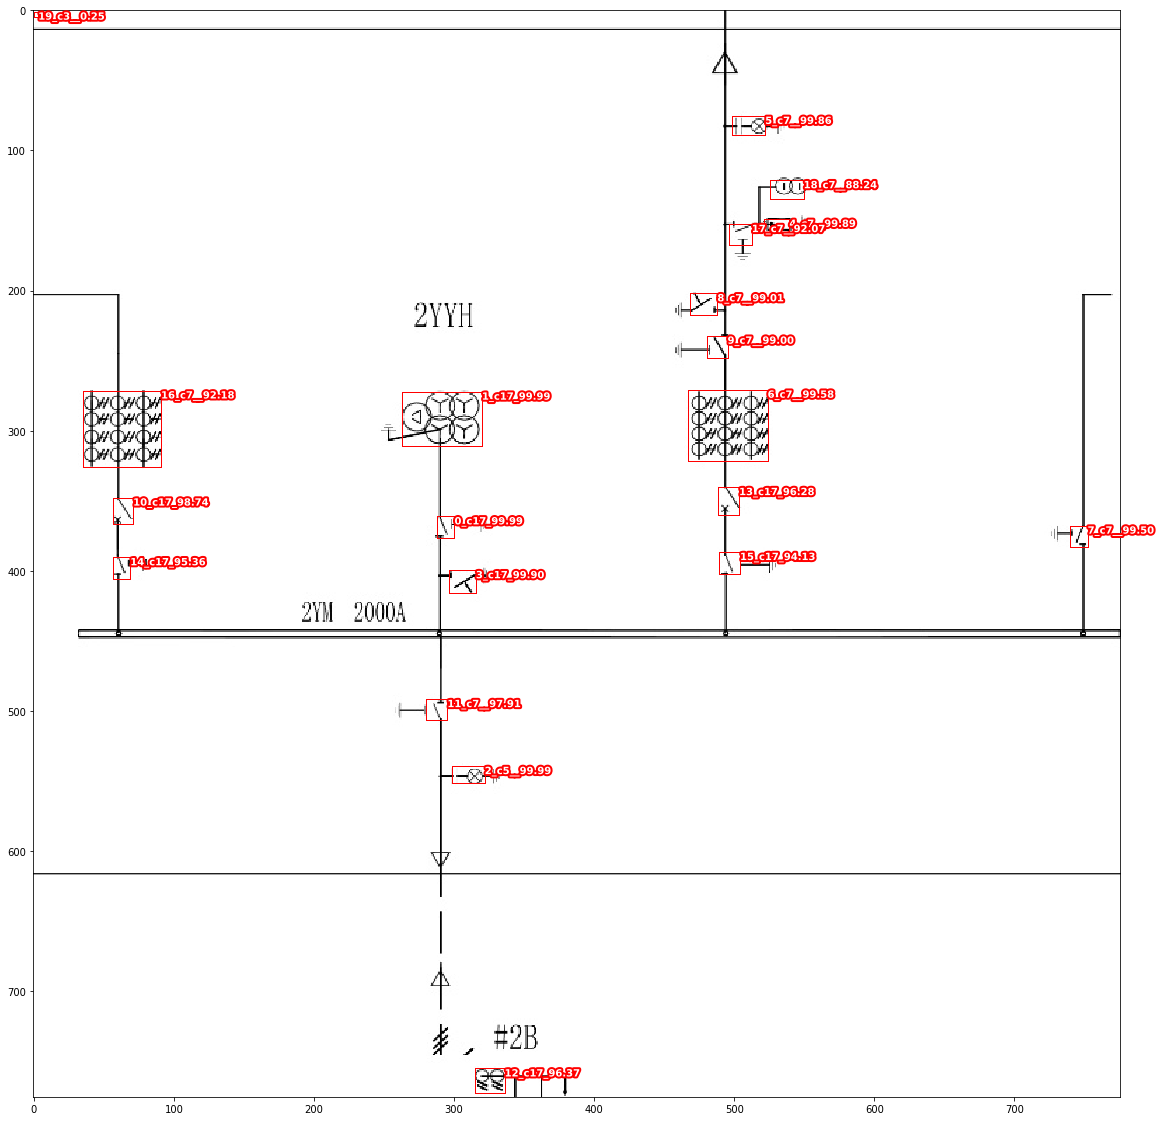

In [74]:
if True:
    bidx = 2
    
    device = torch.device('cuda', 0)
    gvs,_,_,avs,_,_ = anchors_loss_metrics_detsym.get_grids_anchors(fig_hw = (776,776),
                    grids = [(49,49)],
                    anchors = [[(1, 1)]])
    gaf = anchors_loss_metrics_detsym.GridAnchor_Funcs(gvs,avs,device)
    model = resnet_ssd_detsym.ResNetIsh_1SSD(block=torchvision.models.resnet.BasicBlock,
                   layers=[2,2,2],
                   chs=[64,128,256],
                   strides=[1,2,2],
                   pred_layerIds=[2],
                   num_anchors=1,
                   neck_block=resnet_ssd_detsym.cnv1x1_bn_relu,
                   head_chin=256,
                   head_block=resnet_ssd_detsym.ssd_block,
                   num_classes=17)
    learn = Learner(data,model)
    with open('../../detect_symbol/data/ds_20200429/models/run_0_detsym.pth','rb') as f:
        learn.load(f)
    if hasattr(learn.model, "module"): 
        learn.model = model.module
    learn.model.to(device);
    if device.type=='cuda':
        learn.model = torch.nn.DataParallel(model,device_ids=[0])
    learn.model.eval();
    netOut = learn.model(x)
    top_idx=show_top_pred_detsym(x,netOut,20,bidx=bidx)

# export

In [ ]:
!python notebook2script.py --fname 'interpretation.ipynb' --outputDir '../exp/'